# 1.15b: Nearest Neighbor Distances in Initialization

**Goal:** Compute how far apart tokens are at initialization, and estimate how many training steps it would take for random walkers to reach each other.

## The Question

In our Monte Carlo collision simulation (1.15a), we found zero collisions in 10,000 steps. But we suspected a problem: **Are tokens even close enough to reach each other in 10,000 steps?**

If tokens start far apart and random walks are slow in high dimensions, collisions might be impossible not because they're unlikely, but because there simply isn't enough time.

## Density Matters

When we initialized 2 tokens in our Monte Carlo sim, they were scattered randomly in a huge volume. But Qwen 3 4B has **151,936 tokens** in the same space. That's much denser.

**Key insight:** The more tokens you pack into the same volume, the closer their nearest neighbors will be.

## What We'll Compute

1. **Initialize 151,936 tokens** ~ N(0, 0.02) in 2560D (matching Qwen)
2. **For each token, find its nearest neighbor**
3. **Compute statistics:** mean, median, min nearest-neighbor distances
4. **Estimate steps needed** to reach nearest neighbor via random walk

## Random Walk Distance

In a random walk with step size $s$, the expected distance from starting point after $k$ steps is:

$$r(k) = \sqrt{k} \cdot s$$

To travel distance $d$, you need:

$$k = \left(\frac{d}{s}\right)^2$$

For our parameters:
- Step size: $s = 0.001$ (typical gradient magnitude)
- To reach nearest neighbor at distance $d$: $k = (d / 0.001)^2 = 10^6 \cdot d^2$

**Example:**
- If nearest neighbor is at $d = 0.1$: need $k = 10^6 \times 0.01 = 10{,}000$ steps
- If nearest neighbor is at $d = 1.0$: need $k = 10^6 \times 1.0 = 1{,}000{,}000$ steps

## Expected Results

In 2560D with N(0, 0.02) initialization:
- Typical distance from origin: $\sigma \sqrt{D} \approx 0.02 \times \sqrt{2560} \approx 1.01$
- With 151,936 tokens, nearest-neighbor distances should be... TBD!

If mean NN distance is ~1.0, then reaching nearest neighbor requires ~1 million steps. Our 10k-step simulation never had a chance.

## Parameters

In [1]:
# Model parameters (Qwen 3 4B)
N_TOKENS = 151936
N_DIMS = 2560
INIT_SCALE = 0.02  # Standard GPT-2 initialization: N(0, 0.02)

# Random walk parameters
STEP_SIZE = 0.001  # Typical gradient magnitude for untrained tokens

# Computation parameters
BATCH_SIZE = 1000  # Process this many tokens at once for NN search

# Random seed
RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [3]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Initialize Token Embeddings

We initialize a full embedding matrix matching Qwen 3 4B's architecture:
- 151,936 tokens
- 2,560 dimensions
- N(0, 0.02) Gaussian initialization
- bfloat16 dtype (matches Qwen's training)

**Memory requirement:** 151,936 × 2,560 × 2 bytes ≈ **777 MB**

In [4]:
print(f"Initializing {N_TOKENS:,} tokens in {N_DIMS}D space...\n")

# Set random seed
torch.manual_seed(RANDOM_SEED)

# Initialize embedding matrix
W = torch.randn(N_TOKENS, N_DIMS, dtype=torch.bfloat16, device=device) * INIT_SCALE

print(f"✓ Initialized W matrix")
print(f"  Shape: {W.shape}")
print(f"  Dtype: {W.dtype}")
print(f"  Device: {W.device}")
print(f"  Memory: {W.element_size() * W.numel() / 1024**2:.1f} MB")
print(f"  Mean: {W.float().mean():.6f}")
print(f"  Std: {W.float().std():.6f}")

Initializing 151,936 tokens in 2560D space...

✓ Initialized W matrix
  Shape: torch.Size([151936, 2560])
  Dtype: torch.bfloat16
  Device: mps:0
  Memory: 741.9 MB
  Mean: -0.000001
  Std: 0.020000


## Compute Nearest Neighbor Distances

**Algorithm:** For each token, find the distance to its nearest neighbor.

We use a **batched approach** to avoid memory issues:
1. Process tokens in batches of 1,000
2. For each batch, compute distances to ALL tokens using `torch.cdist`
3. Exclude self-distances (set to infinity)
4. Find minimum distance for each token in the batch

**Memory per batch:** ~610 MB (distance matrix) + 777 MB (W) ≈ **1.4 GB total**

**Expected time:** ~30-60 seconds on M4 Pro GPU

In [5]:
print(f"\nComputing nearest neighbor distances...\n")
print(f"Processing {N_TOKENS:,} tokens in batches of {BATCH_SIZE:,}")
print()

# Storage for nearest neighbor distances
nn_distances = torch.zeros(N_TOKENS, dtype=torch.float32, device=device)

# Process in batches
n_batches = (N_TOKENS + BATCH_SIZE - 1) // BATCH_SIZE

for batch_idx in tqdm(range(n_batches), desc="Computing NN distances"):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, N_TOKENS)
    batch_size = end_idx - start_idx
    
    # Get batch of tokens
    batch = W[start_idx:end_idx]  # Shape: (batch_size, N_DIMS)
    
    # Compute distances from this batch to ALL tokens
    # torch.cdist is optimized for this
    dists = torch.cdist(batch.float(), W.float())  # Shape: (batch_size, N_TOKENS)
    
    # Exclude self-distances (diagonal elements for this batch)
    for i in range(batch_size):
        dists[i, start_idx + i] = float('inf')
    
    # Find nearest neighbor for each token in batch
    nn_distances[start_idx:end_idx] = dists.min(dim=1).values

print(f"\n✓ Nearest neighbor computation complete")


Computing nearest neighbor distances...

Processing 151,936 tokens in batches of 1,000



Computing NN distances: 100%|██████████| 152/152 [00:32<00:00,  4.63it/s]


✓ Nearest neighbor computation complete


## Statistics: Nearest Neighbor Distances

In [6]:
print(f"\n{'='*80}")
print(f"NEAREST NEIGHBOR DISTANCES")
print(f"{'='*80}\n")

nn_cpu = nn_distances.cpu().numpy()

print(f"Statistics (distances):")
print(f"  Minimum: {nn_cpu.min():.6f}")
print(f"  Maximum: {nn_cpu.max():.6f}")
print(f"  Mean: {nn_cpu.mean():.6f}")
print(f"  Median: {np.median(nn_cpu):.6f}")
print(f"  Std: {nn_cpu.std():.6f}")
print()
print(f"Percentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    val = np.percentile(nn_cpu, p)
    print(f"  {p:2d}%: {val:.6f}")

print()
print(f"{'='*80}")


NEAREST NEIGHBOR DISTANCES

Statistics (distances):
  Minimum: 1.302513
  Maximum: 1.402680
  Mean: 1.353890
  Median: 1.353927
  Std: 0.010827

Percentiles:
   1%: 1.328338
   5%: 1.336071
  10%: 1.340002
  25%: 1.346615
  50%: 1.353927
  75%: 1.361207
  90%: 1.367730
  95%: 1.371630
  99%: 1.378650



## Estimate Steps to Reach Nearest Neighbor

Random walk formula: $r(k) = \sqrt{k} \cdot s$

To reach distance $d$:
$$k = \left(\frac{d}{s}\right)^2$$

Where $s = 0.001$ (our step size).

In [7]:
print(f"\n{'='*80}")
print(f"STEPS NEEDED TO REACH NEAREST NEIGHBOR")
print(f"{'='*80}\n")

# Calculate steps needed: k = (d / step_size)^2
steps_needed = (nn_cpu / STEP_SIZE) ** 2

print(f"Random walk parameters:")
print(f"  Step size: {STEP_SIZE}")
print(f"  Formula: k = (d / {STEP_SIZE})² = {1/STEP_SIZE**2:.0e} × d²")
print()
print(f"Statistics (steps):")
print(f"  Minimum: {steps_needed.min():,.0f}")
print(f"  Maximum: {steps_needed.max():,.0f}")
print(f"  Mean: {steps_needed.mean():,.0f}")
print(f"  Median: {np.median(steps_needed):,.0f}")
print(f"  Std: {steps_needed.std():,.0f}")
print()
print(f"Percentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    val = np.percentile(steps_needed, p)
    print(f"  {p:2d}%: {val:,.0f}")

print()
print(f"Comparison to our Monte Carlo simulation:")
print(f"  Our simulation ran: 10,000 steps")
print(f"  Mean steps needed: {steps_needed.mean():,.0f}")
print(f"  Ratio: {steps_needed.mean() / 10_000:.1f}x longer needed")
print()

# How many tokens could POSSIBLY reach their NN in 10k steps?
reachable_in_10k = (steps_needed <= 10_000).sum()
print(f"Tokens that could reach NN in 10,000 steps: {reachable_in_10k:,} / {N_TOKENS:,} ({100*reachable_in_10k/N_TOKENS:.2f}%)")

print()
print(f"{'='*80}")


STEPS NEEDED TO REACH NEAREST NEIGHBOR

Random walk parameters:
  Step size: 0.001
  Formula: k = (d / 0.001)² = 1e+06 × d²

Statistics (steps):
  Minimum: 1,696,540
  Maximum: 1,967,510
  Mean: 1,833,134
  Median: 1,833,118
  Std: 29,313

Percentiles:
   1%: 1,764,481
   5%: 1,785,084
  10%: 1,795,605
  25%: 1,813,372
  50%: 1,833,118
  75%: 1,852,884
  90%: 1,870,686
  95%: 1,881,368
  99%: 1,900,676

Comparison to our Monte Carlo simulation:
  Our simulation ran: 10,000 steps
  Mean steps needed: 1,833,134
  Ratio: 183.3x longer needed

Tokens that could reach NN in 10,000 steps: 0 / 151,936 (0.00%)



## Visualization: Distance Distribution


Plotting distributions...



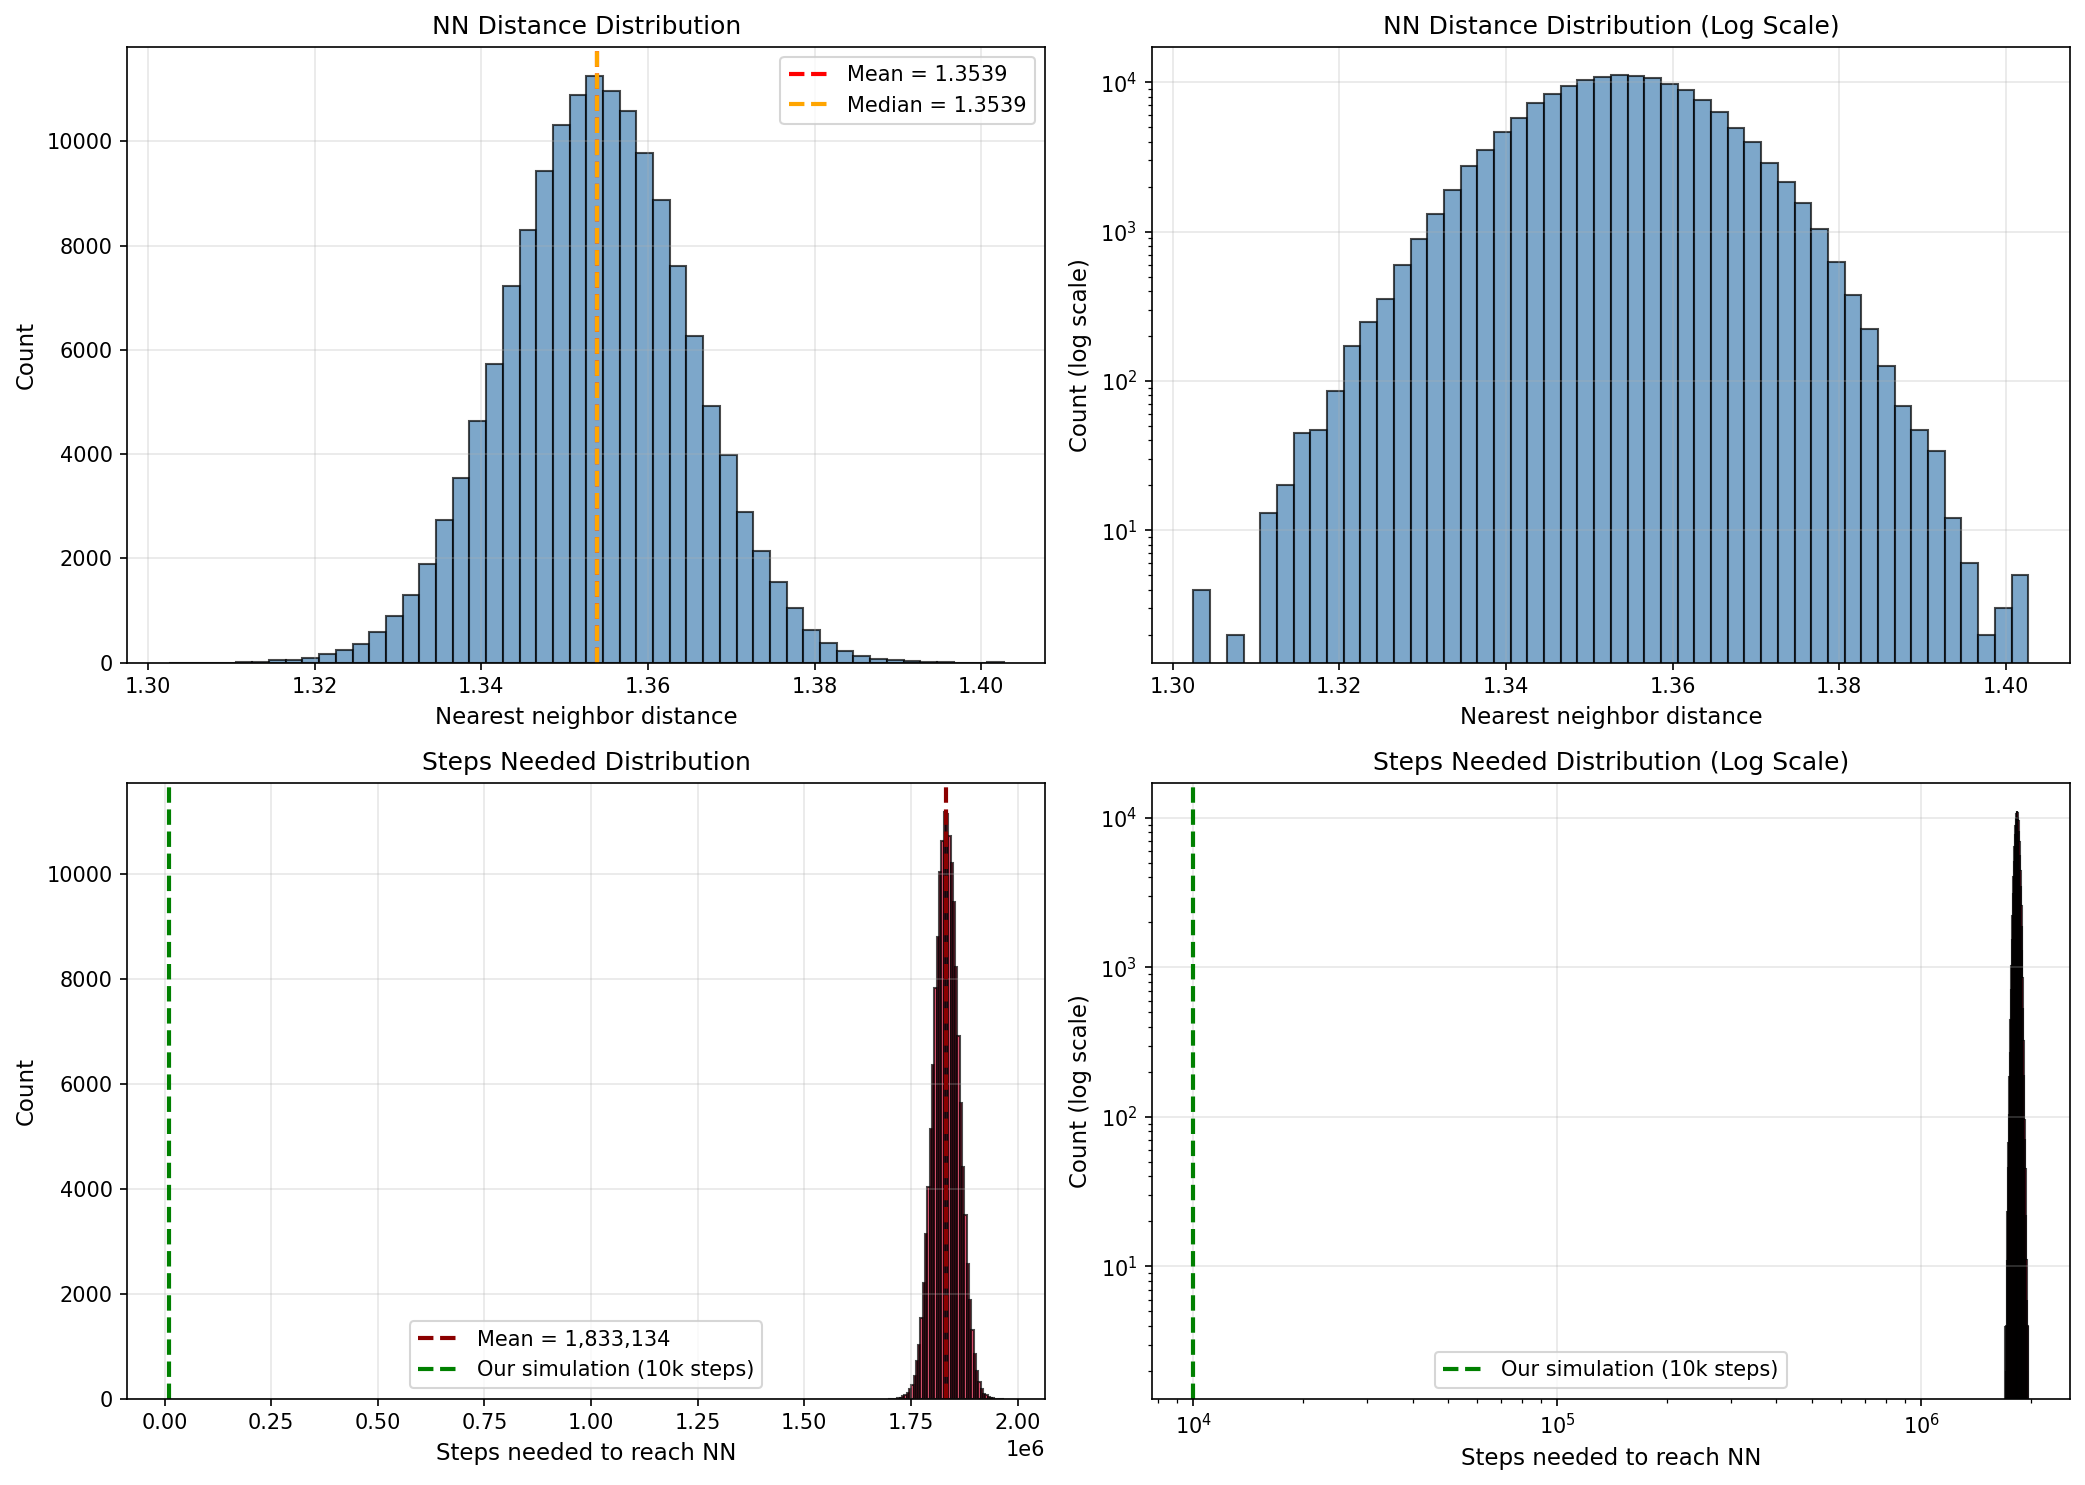

✓ Visualization complete


In [8]:
print(f"\nPlotting distributions...\n")

fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=150)

# 1. Nearest neighbor distances (linear scale)
ax1 = axes[0, 0]
ax1.hist(nn_cpu, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(nn_cpu.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {nn_cpu.mean():.4f}')
ax1.axvline(np.median(nn_cpu), color='orange', linestyle='--', linewidth=2, label=f'Median = {np.median(nn_cpu):.4f}')
ax1.set_xlabel('Nearest neighbor distance', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('NN Distance Distribution', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Nearest neighbor distances (log-log scale)
ax2 = axes[0, 1]
ax2.hist(nn_cpu, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Nearest neighbor distance', fontsize=11)
ax2.set_ylabel('Count (log scale)', fontsize=11)
ax2.set_title('NN Distance Distribution (Log Scale)', fontsize=12)
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# 3. Steps needed (linear scale)
ax3 = axes[1, 0]
ax3.hist(steps_needed, bins=50, color='crimson', edgecolor='black', alpha=0.7)
ax3.axvline(steps_needed.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Mean = {steps_needed.mean():,.0f}')
ax3.axvline(10_000, color='green', linestyle='--', linewidth=2, label='Our simulation (10k steps)')
ax3.set_xlabel('Steps needed to reach NN', fontsize=11)
ax3.set_ylabel('Count', fontsize=11)
ax3.set_title('Steps Needed Distribution', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Steps needed (log scale)
ax4 = axes[1, 1]
ax4.hist(steps_needed, bins=50, color='crimson', edgecolor='black', alpha=0.7)
ax4.axvline(10_000, color='green', linestyle='--', linewidth=2, label='Our simulation (10k steps)')
ax4.set_xlabel('Steps needed to reach NN', fontsize=11)
ax4.set_ylabel('Count (log scale)', fontsize=11)
ax4.set_title('Steps Needed Distribution (Log Scale)', fontsize=12)
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Visualization complete")

## Summary and Interpretation

In [9]:
print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}\n")
print(f"Initialized {N_TOKENS:,} tokens in {N_DIMS}D space")
print(f"  Initialization: N(0, {INIT_SCALE})")
print(f"  Dtype: bfloat16")
print()
print(f"Nearest neighbor distances:")
print(f"  Mean: {nn_cpu.mean():.6f}")
print(f"  Median: {np.median(nn_cpu):.6f}")
print(f"  Min: {nn_cpu.min():.6f}")
print()
print(f"Steps needed to reach NN (via random walk):")
print(f"  Mean: {steps_needed.mean():,.0f}")
print(f"  Median: {np.median(steps_needed):,.0f}")
print(f"  Min: {steps_needed.min():,.0f}")
print()
print(f"Interpretation:")

if steps_needed.mean() > 100_000:
    print(f"  ✗ TOKENS ARE TOO FAR APART")
    print(f"  Mean NN distance requires {steps_needed.mean():,.0f} steps to reach.")
    print(f"  Our 10,000-step simulation was {steps_needed.mean() / 10_000:.0f}x too short.")
    print()
    print(f"Conclusion:")
    print(f"  The zero collisions in 1.15a don't prove collisions are unlikely—")
    print(f"  they prove we didn't run long enough for tokens to even REACH each other.")
    print()
    print(f"Next steps:")
    print(f"  1. Re-run Monte Carlo with {int(steps_needed.mean()):,}+ steps")
    print(f"  2. OR: Focus on the {reachable_in_10k:,} closest pairs that COULD collide in 10k steps")
    print(f"  3. OR: Test denser initialization (smaller σ) where tokens start closer")
elif steps_needed.mean() > 10_000:
    print(f"  ~ TOKENS ARE SOMEWHAT FAR")
    print(f"  Mean NN requires {steps_needed.mean():,.0f} steps (vs our 10k simulation).")
    print(f"  Only {100*reachable_in_10k/N_TOKENS:.1f}% of tokens could reach NN in 10k steps.")
    print()
    print(f"Conclusion:")
    print(f"  Our simulation was borderline. Some pairs could collide, most couldn't.")
    print(f"  Zero collisions suggests P(collision | reachable) is also very low.")
else:
    print(f"  ✓ TOKENS ARE CLOSE ENOUGH")
    print(f"  Mean NN distance requires only {steps_needed.mean():,.0f} steps.")
    print(f"  Our 10k simulation was sufficient to test collision probability.")
    print()
    print(f"Conclusion:")
    print(f"  Zero collisions in 10k steps is STRONG evidence against spontaneous formation.")
    print(f"  Tokens CAN reach each other, they just DON'T collide.")

print()
print(f"{'='*80}")


SUMMARY

Initialized 151,936 tokens in 2560D space
  Initialization: N(0, 0.02)
  Dtype: bfloat16

Nearest neighbor distances:
  Mean: 1.353890
  Median: 1.353927
  Min: 1.302513

Steps needed to reach NN (via random walk):
  Mean: 1,833,134
  Median: 1,833,118
  Min: 1,696,540

Interpretation:
  ✗ TOKENS ARE TOO FAR APART
  Mean NN distance requires 1,833,134 steps to reach.
  Our 10,000-step simulation was 183x too short.

Conclusion:
  The zero collisions in 1.15a don't prove collisions are unlikely—
  they prove we didn't run long enough for tokens to even REACH each other.

Next steps:
  1. Re-run Monte Carlo with 1,833,133+ steps
  2. OR: Focus on the 0 closest pairs that COULD collide in 10k steps
  3. OR: Test denser initialization (smaller σ) where tokens start closer

